In [ ]:
import pickle
from google.colab import files
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime
from geopy.distance import geodesic




# Utils

In [ ]:
def timestamp2dt(timestamp_in_nanos: int = 1695574924084424000):
  timestamp_in_millis = timestamp_in_nanos / 1e6  # Convert to milliseconds
  # Create a datetime object
  dt = datetime.utcfromtimestamp(timestamp_in_millis / 1000)
  # Print the date and time
  return dt

# File upload

In [ ]:
# Upload the "dataset.pkl" file to Colab
uploaded = files.upload()
path = r'C:\Users\joses\Mi unidad\TRABAJO\49_profile_estimation\TRABAJO\experimental\2229-2023-09-24_17-01-55'
# filenames = {'acc': 'AccelerometerUncalibrated.csv',
#              'gyr': 'GyroscopeUncalibrated.csv',
#              'loc': 'Location.csv'}

# 870-2023-09-29_14-45-34
#


Saving AccelerometerUncalibrated.csv to AccelerometerUncalibrated.csv
Saving GyroscopeUncalibrated.csv to GyroscopeUncalibrated.csv
Saving Location.csv to Location.csv


In [73]:
# Load the data from the uploaded file
filenames = {'acc': 'AccelerometerUncalibrated.csv',
             'gyr': 'GyroscopeUncalibrated.csv',
             'loc': 'Location.csv'}


dfs = {k: None for k in filenames.keys()}
for filename in filenames.keys():
  dfs[filename] = pd.read_csv(filenames[filename])


## Time cropping

In [74]:
s_min = 2  # m/s
i_ini = (dfs['loc']['speed'] > s_min).idxmax()
i_fin = (dfs['loc']['speed'].iloc[i_ini:] < s_min).idxmax()
t_ini, t_fin = dfs['loc']['seconds_elapsed'].iloc[i_ini], dfs['loc']['seconds_elapsed'].iloc[i_fin]
print(t_ini, '---', t_fin)
print(timestamp2dt(dfs['loc']['time'].iloc[i_ini]), '---', timestamp2dt(dfs['loc']['time'].iloc[i_fin]))

dfs_crop = {}
if s_min > 0:
  dfs_crop['loc'] = dfs['loc'].loc[i_ini:i_fin, :].copy()
  dfs_crop['acc'] = dfs['acc'].loc[(abs(dfs['acc']['seconds_elapsed']-t_ini)).idxmin():(abs(dfs['acc']['seconds_elapsed']-t_fin)).idxmin(), :].copy()
  dfs_crop['gyr'] = dfs['gyr'].loc[(abs(dfs['gyr']['seconds_elapsed']-t_ini)).idxmin():(abs(dfs['gyr']['seconds_elapsed']-t_fin)).idxmin(), :].copy()
else:
  dfs_crop['loc'] = dfs['loc'].copy()
  dfs_crop['acc'] = dfs['acc'].copy()
  dfs_crop['gyr'] = dfs['gyr'].copy()



8.110423828125 --- 177.13122583007814
2023-09-24 17:02:04.084424 --- 2023-09-24 17:04:53.105226


# Vertical velocity from acc

In [75]:
# Define a function to integrate 'x' with respect to 'seconds_elapsed'
def integrate_x(df_slice):
    # Calculate the integral of 'x' over 'seconds_elapsed' in the slice
    integral = df_slice.sum()
    return integral

# Remove moving mean
acc_delta_t = 0.01 # s
mean_window_length_s = 10. # s
mean_window = int(mean_window_length_s/acc_delta_t)
dfs_crop['acc']['x_rem_mean'] = dfs_crop['acc']['x'] - (1/mean_window)*dfs_crop['acc'].rolling(
    window=mean_window)['x'].apply(integrate_x, raw=True)
dfs_crop['acc']['y_rem_mean'] = dfs_crop['acc']['y'] - (1/mean_window)*dfs_crop['acc'].rolling(
    window=mean_window)['y'].apply(integrate_x, raw=True)
dfs_crop['acc']['z_rem_mean'] = dfs_crop['acc']['z'] - (1/mean_window)*dfs_crop['acc'].rolling(
    window=mean_window)['z'].apply(integrate_x, raw=True)

# Apply the rolling window and integrate over a 1-second window
window_length_s = 1.00
dfs_crop['acc']['vel_x'] = acc_delta_t*dfs_crop['acc'].rolling(
    window=int(window_length_s/acc_delta_t))['x_rem_mean'].apply(integrate_x, raw=True)
dfs_crop['acc']['vel_y'] = acc_delta_t*dfs_crop['acc'].rolling(
    window=int(window_length_s/acc_delta_t))['y_rem_mean'].apply(integrate_x, raw=True)
dfs_crop['acc']['vel_z'] = acc_delta_t*dfs_crop['acc'].rolling(
    window=int(window_length_s/acc_delta_t))['z_rem_mean'].apply(integrate_x, raw=True)

# Remove nans
first_not_nan = np.argmin(np.isnan(dfs_crop['acc']['vel_x']))
dfs_crop['acc'] = dfs_crop['acc'].iloc[first_not_nan:, :].copy()
dfs_crop['acc']


,time,seconds_elapsed,z,y,x,x_rem_mean,y_rem_mean,z_rem_mean,vel_x,vel_y,vel_z
1884,1.695570e+18,19.040977,-0.296881,-0.512359,9.093178,-0.646712,-0.387075,-0.090515,-0.000005,-0.364394,0.212002
1885,1.695570e+18,19.050928,-0.512359,-0.158017,10.175357,0.435414,-0.031460,-0.305376,0.009259,-0.358773,0.195983
1886,1.695570e+18,19.060879,-0.430956,-0.186748,10.697293,0.957202,-0.058375,-0.223384,0.020376,-0.355986,0.189024
1887,1.695570e+18,19.070831,-0.354342,0.129287,10.304645,0.564261,0.258885,-0.145884,0.022713,-0.349962,0.187141
1888,1.695570e+18,19.080782,-0.081403,-0.172383,9.686940,-0.053304,-0.041252,0.126404,0.017569,-0.351806,0.194803
...,...,...,...,...,...,...,...,...,...,...,...
17766,1.695580e+18,177.087283,-0.723049,-0.483629,9.074024,-0.689119,-0.357335,-0.661547,0.076248,-1.483564,1.472168
17767,1.695580e+18,177.097235,-0.679953,-0.952892,8.839393,-0.922797,-0.823447,-0.616732,0.066005,-1.473037,1.439887
17768,1.695580e+18,177.107186,-0.502782,-1.043872,9.059659,-0.701487,-0.911219,-0.437325,0.060172,-1.467819,1.410457
17769,1.695580e+18,177.117138,0.799663,-1.259350,9.461885,-0.298552,-1.122948,0.866256,0.056833,-1.466801,1.401963


# File visualization

## Before croping

(3.433223876953125, 201.1398965)

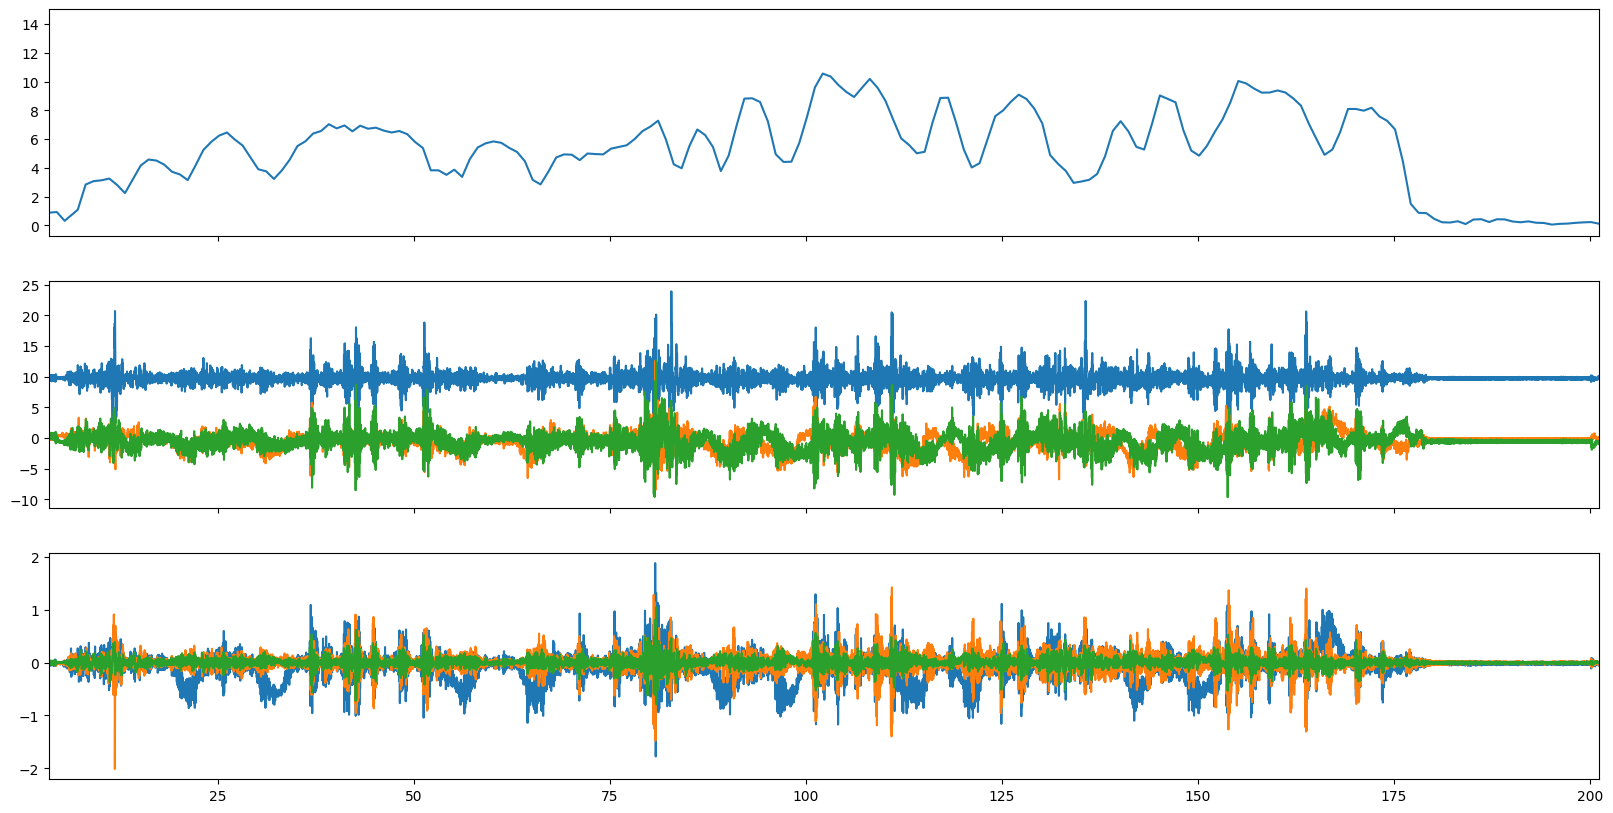

In [76]:
fig, ax = plt.subplots(3, 1, sharex='col', figsize=(20,10))
ax[0].plot(dfs['loc']['seconds_elapsed'], dfs['loc']['speed'])
ax[1].plot(dfs['acc']['seconds_elapsed'], dfs['acc']['x'])
ax[1].plot(dfs['acc']['seconds_elapsed'], dfs['acc']['y'])
ax[1].plot(dfs['acc']['seconds_elapsed'], dfs['acc']['z'])
ax[2].plot(dfs['gyr']['seconds_elapsed'], dfs['gyr']['x'])
ax[2].plot(dfs['gyr']['seconds_elapsed'], dfs['gyr']['y'])
ax[2].plot(dfs['gyr']['seconds_elapsed'], dfs['gyr']['z'])
ax[0].set_xlim((max((min(dfs['loc']['seconds_elapsed']), min(dfs['acc']['seconds_elapsed']), min(dfs['gyr']['seconds_elapsed'])))),
                min((max(dfs['loc']['seconds_elapsed']), max(dfs['acc']['seconds_elapsed']), max(dfs['gyr']['seconds_elapsed']))))

## After cropping

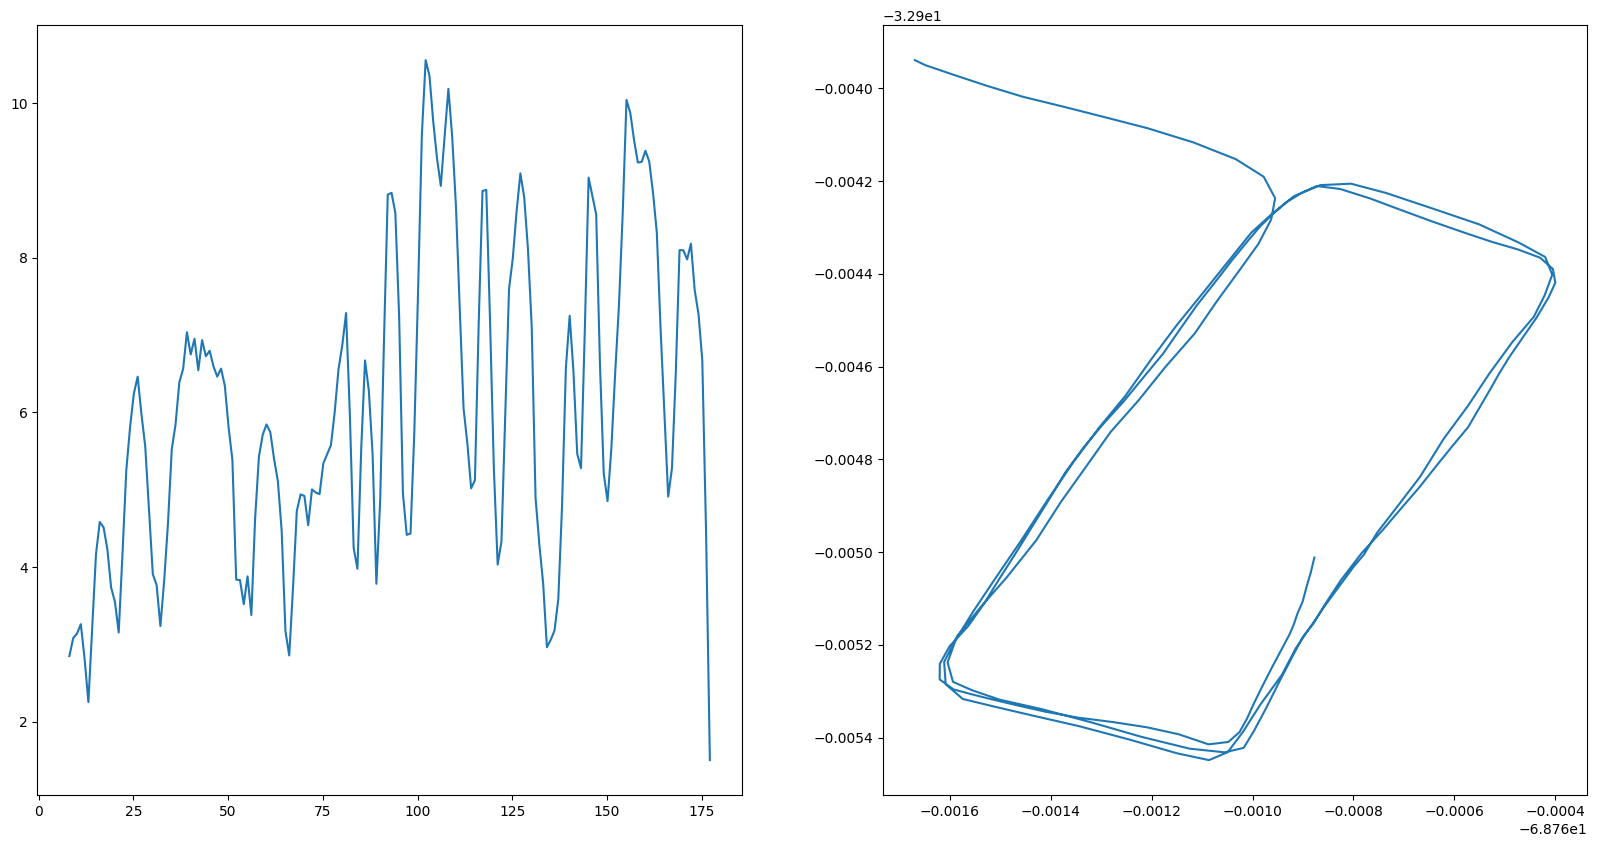

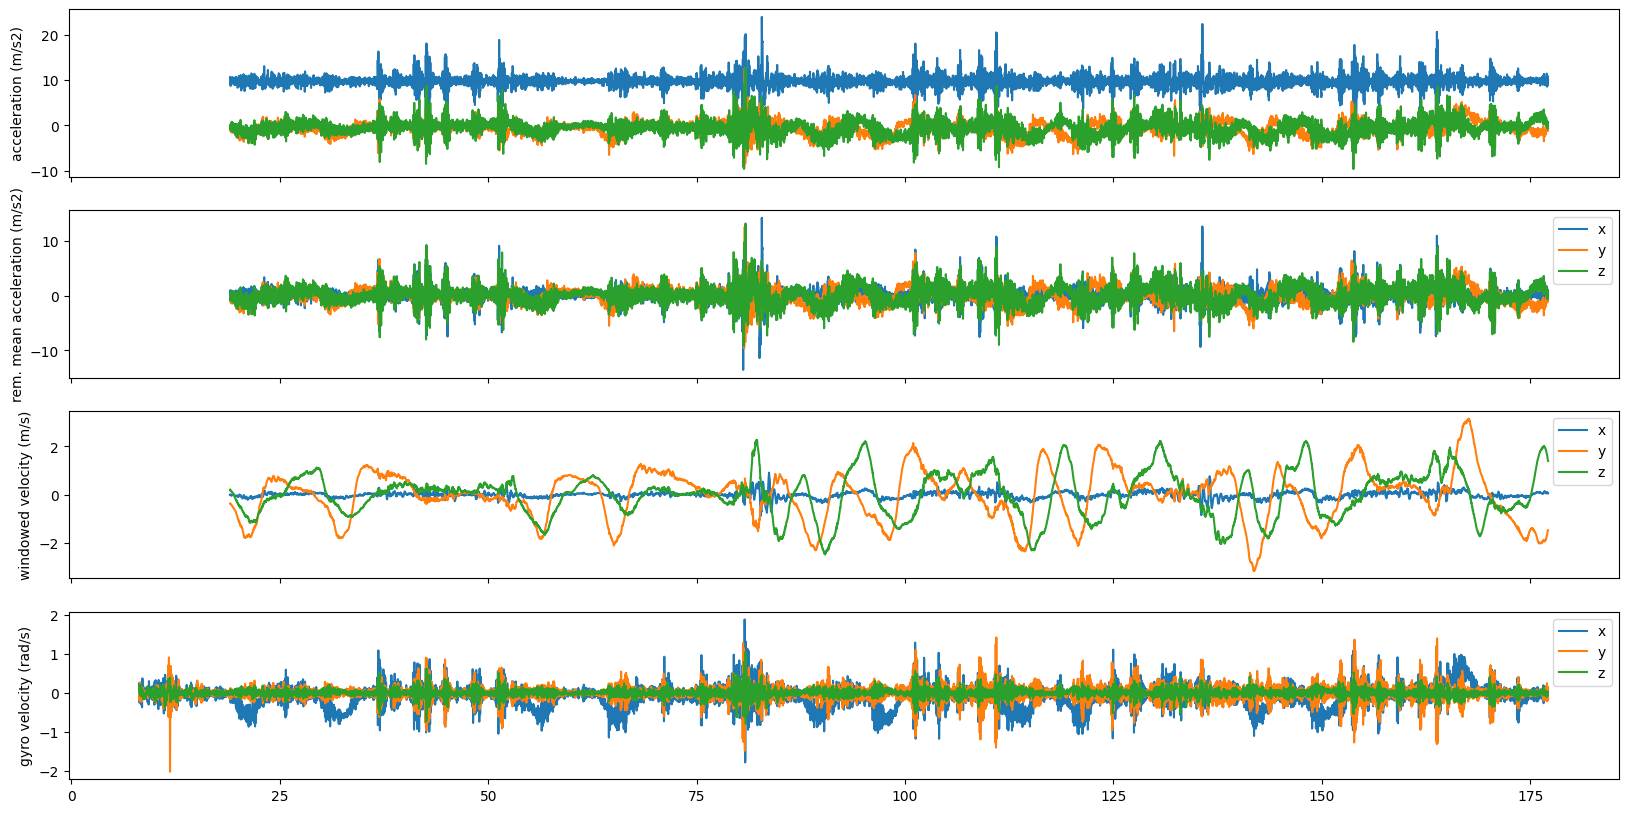

In [77]:
set_xlim = False

fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].plot(dfs_crop['loc']['seconds_elapsed'], dfs_crop['loc']['speed'])
ax[1].plot(dfs_crop['loc']['longitude'], dfs_crop['loc']['latitude'])

fig, ax = plt.subplots(4, 1, sharex='col', figsize=(20,10))
ax[0].plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['x'], label='x')
ax[0].plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['y'], label='y')
ax[0].plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['z'], label='z')
ax[0].set_ylabel('acceleration (m/s2)')
ax[1].plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['x_rem_mean'], label='x')
ax[1].plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['y_rem_mean'], label='y')
ax[1].plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['z_rem_mean'], label='z')
ax[1].set_ylabel('rem. mean acceleration (m/s2)')
ax[1].legend()
ax[2].plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['vel_x'], label='x')
ax[2].plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['vel_y'], label='y')
ax[2].plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['vel_z'], label='z')
ax[2].set_ylabel('windowed velocity (m/s)')
ax[2].legend()
ax[3].plot(dfs_crop['gyr']['seconds_elapsed'], dfs_crop['gyr']['x'], label='x')
ax[3].plot(dfs_crop['gyr']['seconds_elapsed'], dfs_crop['gyr']['y'], label='y')
ax[3].plot(dfs_crop['gyr']['seconds_elapsed'], dfs_crop['gyr']['z'], label='z')
ax[3].set_ylabel('gyro velocity (rad/s)')
ax[3].legend()
if set_xlim:
  ax[0].set_xlim((max((min(dfs['loc']['seconds_elapsed']), min(dfs['acc']['seconds_elapsed']), min(dfs['gyr']['seconds_elapsed'])))),
                  min((max(dfs['loc']['seconds_elapsed']), max(dfs['acc']['seconds_elapsed']), max(dfs['gyr']['seconds_elapsed']))))

# Auto correlation in time and space domain

## Pass to space domain

In [78]:
dfs_crop['loc'].loc[:, 'distance_from_speed'] = dfs_crop['loc'].loc[:, 'speed'].cumsum()

# Replace NaN values with zeros in the 'latitude' and 'longitude' columns
dfs_crop['loc']['latitude'].fillna(0, inplace=True)
dfs_crop['loc']['longitude'].fillna(0, inplace=True)

# Create an empty list to store distances
distances = []

# Iterate over the DataFrame rows, skipping the first and last rows
for i in range(1, len(dfs_crop['loc']) - 1):
    lat1 = dfs_crop['loc']['latitude'].iloc[i - 1]
    lon1 = dfs_crop['loc']['longitude'].iloc[i - 1]
    lat2 = dfs_crop['loc']['latitude'].iloc[i + 1]
    lon2 = dfs_crop['loc']['longitude'].iloc[i + 1]
    distance = geodesic((lat1, lon1), (lat2, lon2)).m
    distances.append(distance)

# Add the distances to the DataFrame
dfs_crop['loc']['distances'] = [None] + distances + [None]
dfs_crop['loc']['distance_from_latlong'] = dfs_crop['loc']['distances'].cumsum()
# dfs_crop['loc']

## Autocorrelation in space domain

### Using distance from speed

In [79]:
dfs_crop['acc']['speed'] = np.nan
dfs_crop['gyr']['speed'] = np.nan

for t, s in zip(dfs_crop['loc']['seconds_elapsed'],
                dfs_crop['loc']['speed']):
  id = (abs(t - dfs_crop['acc']['seconds_elapsed'])).idxmin()
  dfs_crop['acc']['speed'][id] = s

for t, s in zip(dfs_crop['loc']['seconds_elapsed'],
                dfs_crop['loc']['speed']):
  id = (abs(t - dfs_crop['gyr']['seconds_elapsed'])).idxmin()
  dfs_crop['gyr']['speed'][id] = s

dfs_crop['acc']['speed'].interpolate('cubicspline', inplace=True)
dfs_crop['acc']['distance_from_speed'] = acc_delta_t*dfs_crop['acc']['speed'].cumsum()

dfs_crop['gyr']['speed'].interpolate('cubicspline', inplace=True)
dfs_crop['gyr']['distance_from_speed'] = acc_delta_t*dfs_crop['gyr']['speed'].cumsum()

# dfs_crop['acc']

Text(0.5, 0, 'distance (m)')

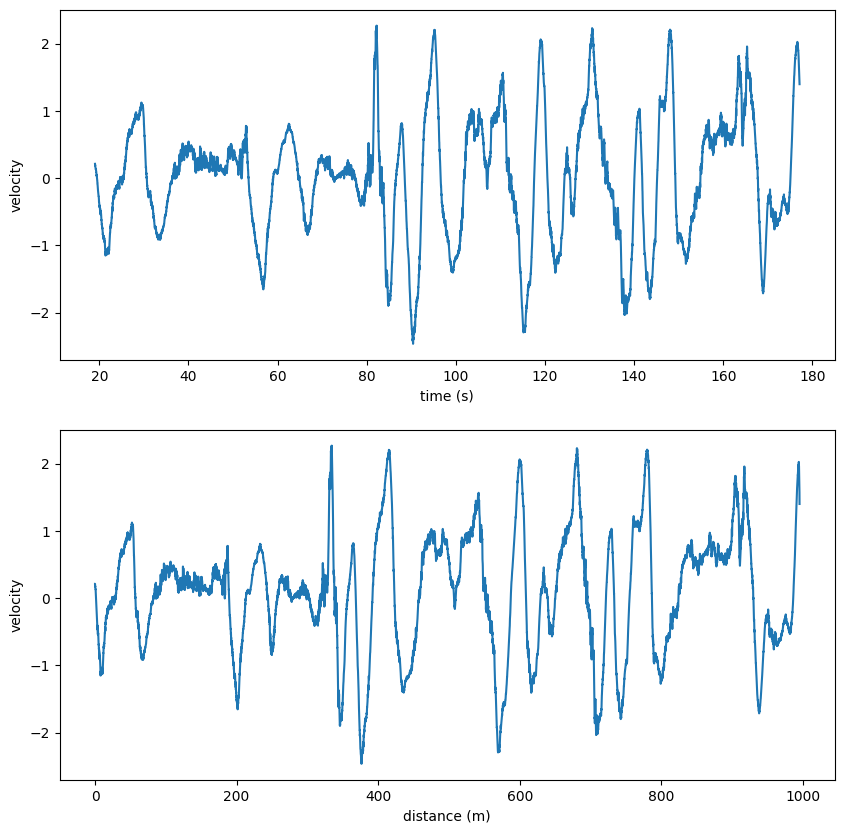

In [80]:
delta_space = 0.01  # m

dfs_crop_space = {}

distance_from_speed = np.arange(0, dfs_crop['acc']['distance_from_speed'].iloc[-1], delta_space)
dfs_crop_space['acc'] = pd.DataFrame({'distance_from_speed': distance_from_speed,
                                      'x_rem_mean': np.interp(distance_from_speed, dfs_crop['acc']['distance_from_speed'], dfs_crop['acc']['x_rem_mean']),
                                      'y_rem_mean': np.interp(distance_from_speed, dfs_crop['acc']['distance_from_speed'], dfs_crop['acc']['y_rem_mean']),
                                      'z_rem_mean': np.interp(distance_from_speed, dfs_crop['acc']['distance_from_speed'], dfs_crop['acc']['z_rem_mean']),
                                      'vel_x': np.interp(distance_from_speed, dfs_crop['acc']['distance_from_speed'], dfs_crop['acc']['vel_x']),
                                      'vel_y': np.interp(distance_from_speed, dfs_crop['acc']['distance_from_speed'], dfs_crop['acc']['vel_y']),
                                      'vel_z': np.interp(distance_from_speed, dfs_crop['acc']['distance_from_speed'], dfs_crop['acc']['vel_z'])})
dfs_crop_space['gyr'] = pd.DataFrame({'distance_from_speed': distance_from_speed,
                                      'x': np.interp(distance_from_speed, dfs_crop['gyr']['distance_from_speed'], dfs_crop['gyr']['x']),
                                      'y': np.interp(distance_from_speed, dfs_crop['gyr']['distance_from_speed'], dfs_crop['gyr']['y']),
                                      'z': np.interp(distance_from_speed, dfs_crop['gyr']['distance_from_speed'], dfs_crop['gyr']['z'])})
fig, ax = plt.subplots(2, 1, figsize=(10,10))
ax[0].plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['vel_z'])
ax[0].set_ylabel('velocity')
ax[0].set_xlabel('time (s)')
ax[1].plot(dfs_crop_space['acc']['distance_from_speed'], dfs_crop_space['acc']['vel_z'])
ax[1].set_ylabel('velocity')
ax[1].set_xlabel('distance (m)')

# dfs_crop_space['acc']

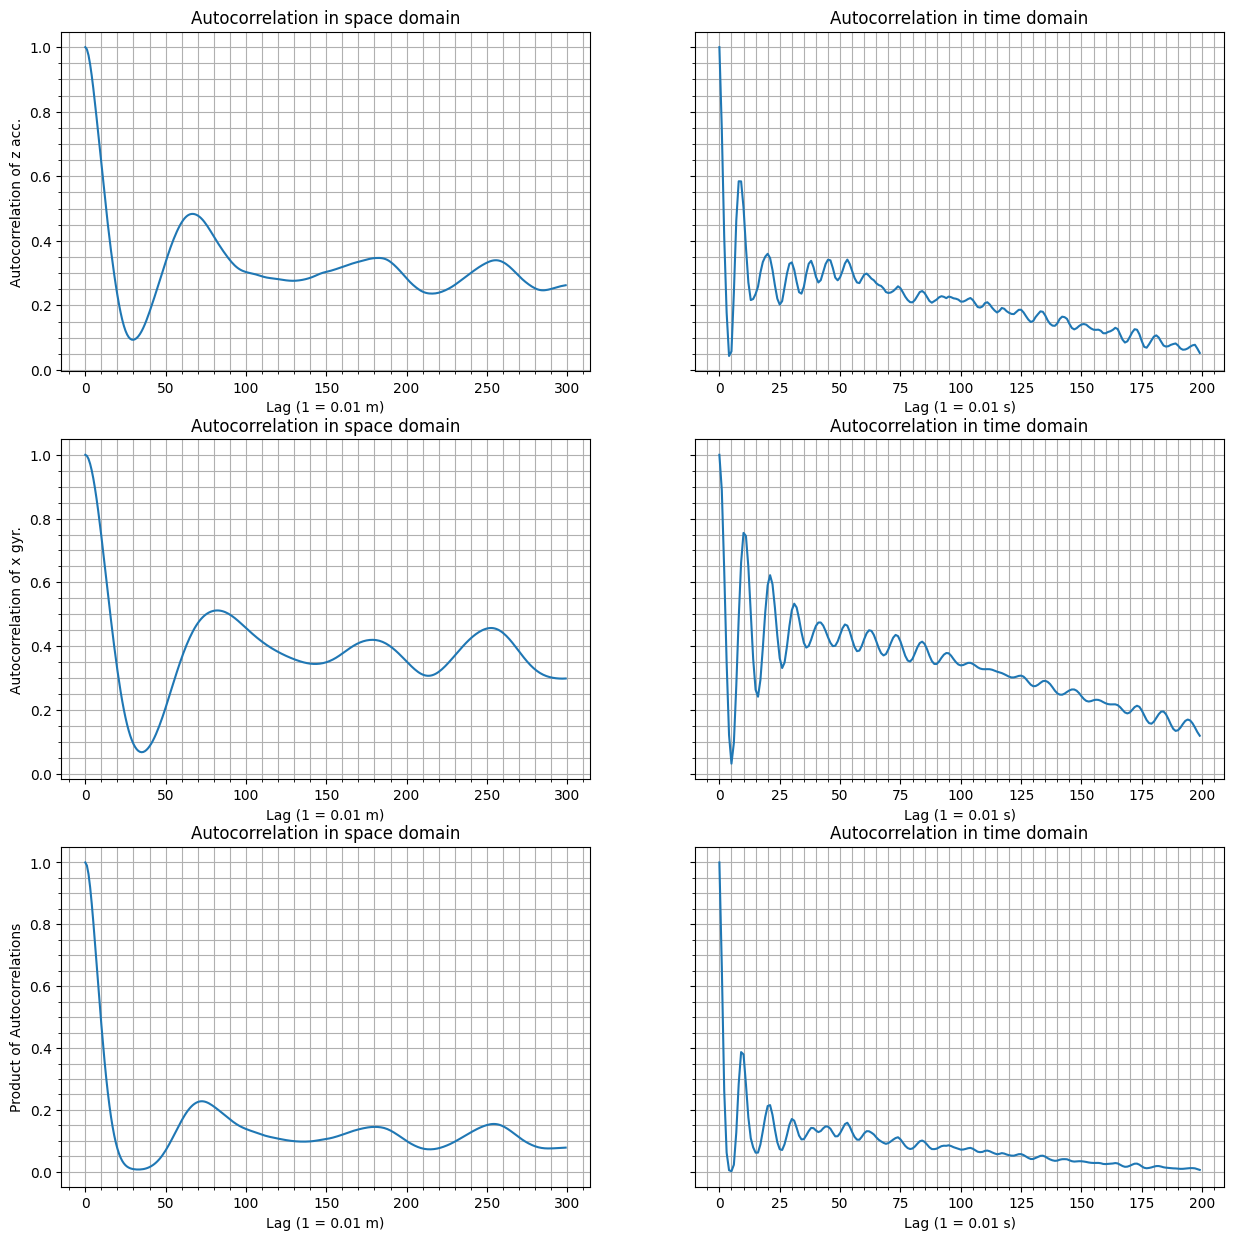

In [81]:
# Calculates autocorrelation function in time domain
autocorrelation_z_acc = []
autocorrelation_x_gyr = []
lags = 200
for lag in range(lags):
  autocorrelation_z_acc.append(dfs_crop['acc']['z_rem_mean'].autocorr(lag))
  autocorrelation_x_gyr.append(dfs_crop['gyr']['x'].autocorr(lag))
autocorrelation_z_acc = np.array(autocorrelation_z_acc)
autocorrelation_x_gyr = np.array(autocorrelation_x_gyr)

# Calculates autocorrelation function in space domain
autocorrelation_space_z_acc = []
autocorrelation_space_x_gyr = []
lags = 300
for lag in range(lags):
  autocorrelation_space_z_acc.append(dfs_crop_space['acc']['z_rem_mean'].autocorr(lag))
  autocorrelation_space_x_gyr.append(dfs_crop_space['gyr']['x'].autocorr(lag))
autocorrelation_space_z_acc = np.array(autocorrelation_space_z_acc)
autocorrelation_space_x_gyr = np.array(autocorrelation_space_x_gyr)

# Plots autocorrelation function of vertical acc
fig, ax = plt.subplots(3, 2, sharey='row', figsize=(15, 15))
ax[0,0].plot(autocorrelation_space_z_acc)
ax[0,0].set_title('Autocorrelation in space domain')
ax[0,0].set_xlabel(f'Lag (1 = {delta_space} m)')
ax[0,0].set_ylabel('Autocorrelation of z acc.')
ax[0,0].minorticks_on()
ax[0,0].grid(which='both')

ax[0,1].plot(autocorrelation_z_acc)
ax[0,1].set_title('Autocorrelation in time domain')
ax[0,1].set_xlabel(f'Lag (1 = {acc_delta_t} s)')
ax[0,1].minorticks_on()
ax[0,1].grid(which='both')

# Plots autocorrelation function of gyr
ax[1,0].plot(autocorrelation_space_x_gyr)
ax[1,0].set_title('Autocorrelation in space domain')
ax[1,0].set_xlabel(f'Lag (1 = {delta_space} m)')
ax[1,0].set_ylabel('Autocorrelation of x gyr.')
ax[1,0].minorticks_on()
ax[1,0].grid(which='both')

ax[1,1].plot(autocorrelation_x_gyr)
ax[1,1].set_title('Autocorrelation in time domain')
ax[1,1].set_xlabel(f'Lag (1 = {acc_delta_t} s)')
ax[1,1].minorticks_on()
ax[1,1].grid(which='both')

# Plots product of autocorrelations
ax[2,0].plot(autocorrelation_space_x_gyr * autocorrelation_space_z_acc)
ax[2,0].set_title('Autocorrelation in space domain')
ax[2,0].set_xlabel(f'Lag (1 = {delta_space} m)')
ax[2,0].set_ylabel('Product of Autocorrelations')
ax[2,0].minorticks_on()
ax[2,0].grid(which='both')

ax[2,1].plot(autocorrelation_x_gyr * autocorrelation_z_acc)
ax[2,1].set_title('Autocorrelation in time domain')
ax[2,1].set_xlabel(f'Lag (1 = {acc_delta_t} s)')
ax[2,1].minorticks_on()
ax[2,1].grid(which='both')


plt.show()

### Longitudinal acceleration

(0.0, 170.0)

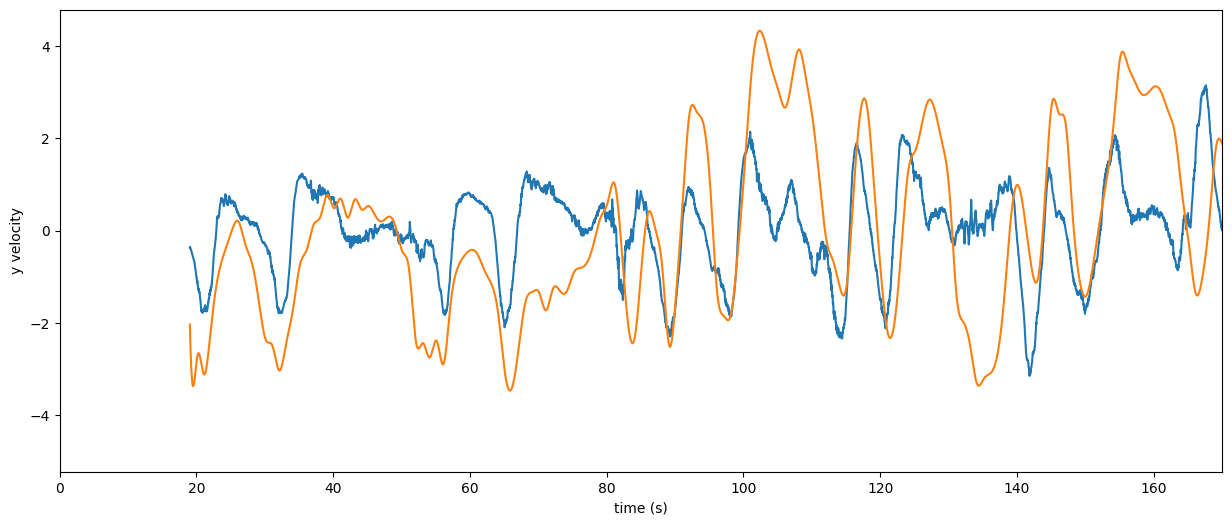

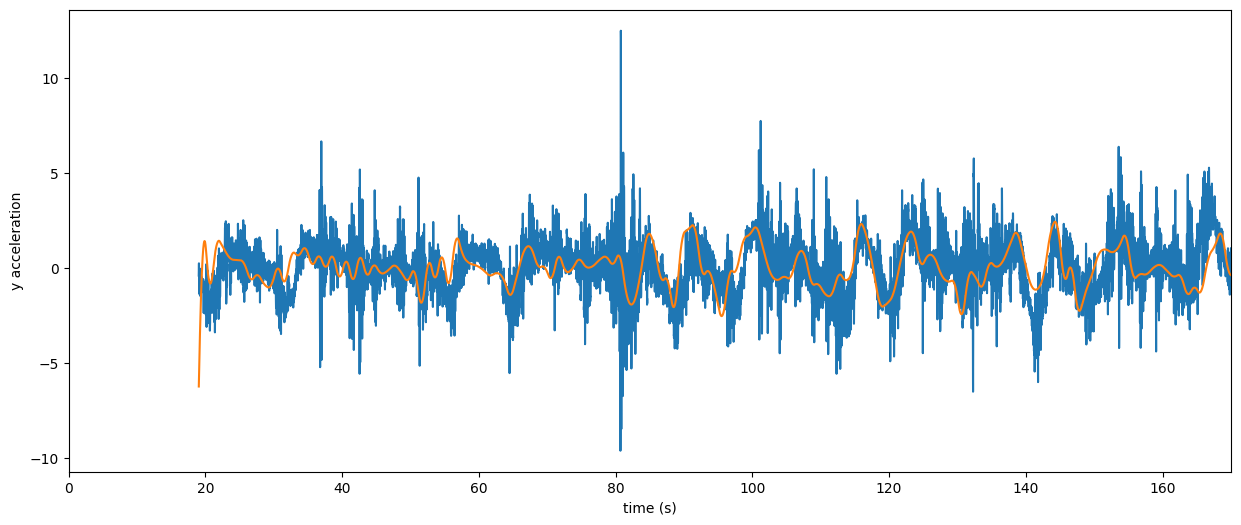

In [82]:
tlims = (0, 170)
plt.figure(figsize=(15,6))
plt.plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['vel_y'])
plt.plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['speed'] - dfs_crop['acc']['speed'].mean())
plt.xlabel('time (s)')
plt.ylabel('y velocity')
plt.xlim(tlims)

plt.figure(figsize=(15,6))
plt.plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['y_rem_mean'])
plt.plot(dfs_crop['acc']['seconds_elapsed'], dfs_crop['acc']['speed'].diff()/acc_delta_t)
plt.xlabel('time (s)')
plt.ylabel('y acceleration')
plt.xlim(tlims)

# Spectrograms

## Spectrograms of temporal

### Utils

In [83]:
def batch_extractor(time: np.ndarray, response: np.ndarray, batch_length_s: float, ret_time_batches: bool = False,
                    runing: bool = True, as_nparray: bool = False):
    time_batches = []
    response_batches = []
    if runing:
        batch_length = int(batch_length_s // (time[1] - time[0]))
        n_batches = len(time) - batch_length
    else:
        n_batches = int(time[-1] // batch_length_s)
        batch_length = int(len(time) // n_batches)
    for i_batch in range(n_batches):
        if runing:
            i_ini, i_fin = i_batch, i_batch + batch_length
        else:
            i_ini, i_fin = i_batch * batch_length, (i_batch + 1) * batch_length
        time_batches.append(time[i_ini:i_fin])
        response_batches.append(response[i_ini:i_fin])
    if ret_time_batches:
        if as_nparray:
            return np.array(response_batches), np.array(time_batches)
        else:
            return response_batches, time_batches
    else:
        if as_nparray:
            return np.array(response_batches)
        else:
            return response_batches


class DiagonalDense(tf.keras.layers.Layer):
    def __init__(self, units, kernel_initializer, polynomial_kernel_degree: Union[None, int] = None, **kwargs):
        if polynomial_kernel_degree is not None:
            assert isinstance(polynomial_kernel_degree, int)
            assert polynomial_kernel_degree < units
        self.polynomial_kernel_degree = polynomial_kernel_degree
        self.kernel_initializer = kernel_initializer
        self.kernel = None
        self.kernel_coef = None
        self.kernel_basis = None
        self.units = units
        super(DiagonalDense, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.polynomial_kernel_degree is None:
            self.kernel = self.add_weight("kernel", shape=(self.units,), initializer=self.kernel_initializer,
                                          trainable=True, constraint=tf.keras.constraints.NonNeg())
        else:
            self.kernel_coef = self.add_weight("kernel_coef", shape=(self.polynomial_kernel_degree, 1),
                                               initializer=self.kernel_initializer, trainable=True)
            self.kernel = self.add_weight("kernel", shape=(self.units,), initializer=self.kernel_initializer,
                                          trainable=False, constraint=tf.keras.constraints.NonNeg())
            # Define the degree of the Legendre polynomial
            degree = self.polynomial_kernel_degree  # Replace with your degree value
            length = self.units
            domain = (0, length - 1)
            basis = np.zeros((length, degree))
            for row in range(length):  # Calculate Legendre polynomials for each row
                for col in range(degree):
                    polynomial = np.polynomial.legendre.Legendre.basis(col, domain)
                    # Evaluate the Legendre polynomial at the desired point (0.0 for Legendre polynomials)
                    basis[row, col] = polynomial(row)
            self.kernel_basis = self.add_weight("basis", shape=(length, degree), initializer='ones',
                                                trainable=False)
            self.kernel_basis.assign(basis)

    def call(self, inputs, **kwargs):
        if self.polynomial_kernel_degree is None:
            z = self.kernel * inputs
        else:
            kernel = self.kernel_basis @ self.kernel_coef
            self.kernel.assign(tf.reshape(kernel, (-1,)))
            z = tf.reshape(kernel, (-1,)) * inputs
        return z



### Calculation

In [84]:
x = dfs_crop['acc']['z_rem_mean'].values
time = dfs_crop['acc']['seconds_elapsed'].values

batch_length_s = 1.
delta_t = acc_delta_t
x_train, x_time_batches = batch_extractor(time, x, batch_length_s, runing=True,
                                          ret_time_batches=True, as_nparray=True)

batch_size = x_train.shape[1]
# Frequency domain
freq = np.fft.fftfreq(len(x_time_batches[0]), delta_t)
x_train_fd = np.abs(np.fft.fft(x_train, axis=1)[:, :len(freq) // 2])
freq = freq[:len(freq) // 2]
input_shape = (x_train_fd.shape[1],)


### Plot in time domain

Text(0.5, 1.0, 'Spectrogram of vert. acc.')

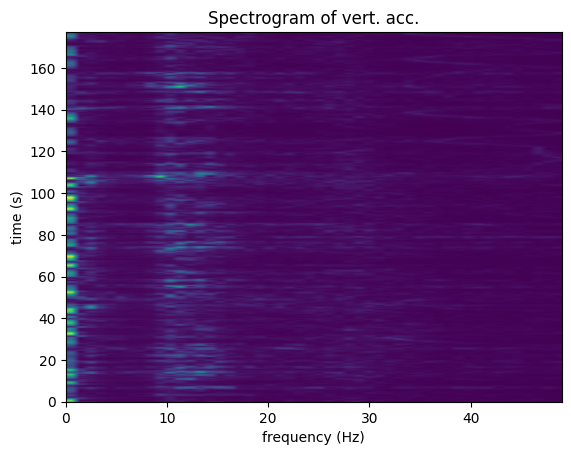

In [85]:
acc_car = x_train_fd
vmin, vmax = np.min(acc_car), np.max(acc_car)

fig, ax = plt.subplots(1,1)
ax.imshow(acc_car, extent=[0, freq[-1], 0, time[-1]], aspect='auto',
           cmap='viridis', vmin=vmin, vmax=vmax)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('time (s)')
ax.set_title('Spectrogram of vert. acc.')

### Plot in space domain

# Predictive models

In [86]:
from typing import Union

from keras.models import Sequential
from keras.layers import Normalization
from keras.optimizers import Adam
from keras import regularizers, Input

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.src.layers import Conv1D, Lambda, Layer

In [87]:
# input_x1 = Input(shape=self.input_shape)
# input_x2 = Input(shape=self.input_shape)

# # Apply shared Conv1D layers to each element of the input tensor
# deg = self.polynomial_kernel_degree
# diag1 = DiagonalDense(units=self.input_shape[0], kernel_initializer='ones',
#                       polynomial_kernel_degree=deg)(input_x1)
# diag2 = DiagonalDense(units=self.input_shape[0], kernel_initializer='ones',
#                       polynomial_kernel_degree=deg)(input_x2)


# Training dataset

# Train

## JointIdentificationSimple


## Plot training results